# Project Overview

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Business Case/Problem

## Data Description

## Data Load

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Features to remove: 
- 'yr_renovated': large number of missing data.

## Data Cleaning

Let's review columns to see which ones make the most sense to keep.

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'sqft_basement',
                  'yr_built',
                  'zipcode'
                  ]

In [7]:
def filter_columns(df):
    columns_to_keep = ['price','bedrooms', 
                   'bathrooms', 
                   'sqft_living', 
                   'sqft_lot', 
                   'floors', 
                   'condition',
                  'grade',
                  'sqft_above',
                  'yr_built',
                  'zipcode'
                  ]
    return df[columns_to_keep]

In [8]:
df_filtered = filter_columns(df)
df_filtered.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,98125
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,98074


In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   condition    21597 non-null  int64  
 7   grade        21597 non-null  int64  
 8   sqft_above   21597 non-null  int64  
 9   yr_built     21597 non-null  int64  
 10  zipcode      21597 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.8 MB


## Split Data into Training and Test set

In [10]:
target = df_filtered['price']
features = df_filtered.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size=0.2,random_state=42)
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode
6243,4,2.00,1440,4855,2.0,4,7,1440,1972,98144
8986,3,1.75,1430,9857,1.0,4,7,1140,1980,98045
9419,4,2.75,3120,5000,2.0,3,9,3120,2010,98074
10155,4,2.50,2060,6958,1.0,3,7,1220,1974,98034
10436,3,2.00,2500,4080,1.5,5,7,1680,1922,98103


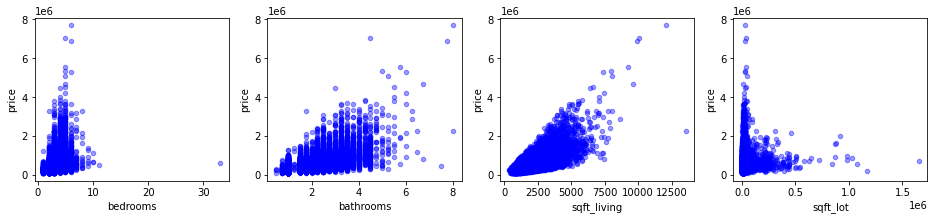

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 
                     'bathrooms',
                     'sqft_living',
                     'sqft_lot', 
                     ], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

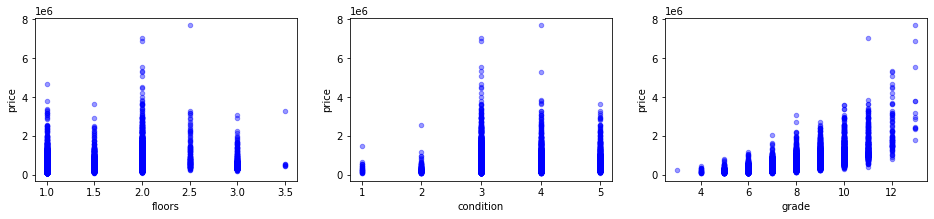

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['floors',
                     'condition',
                     'grade'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

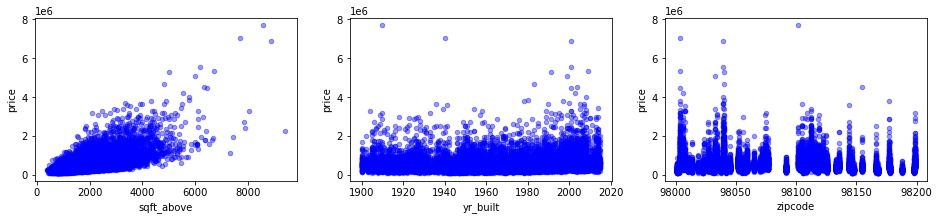

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_above',
                    'yr_built',
                    'zipcode'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

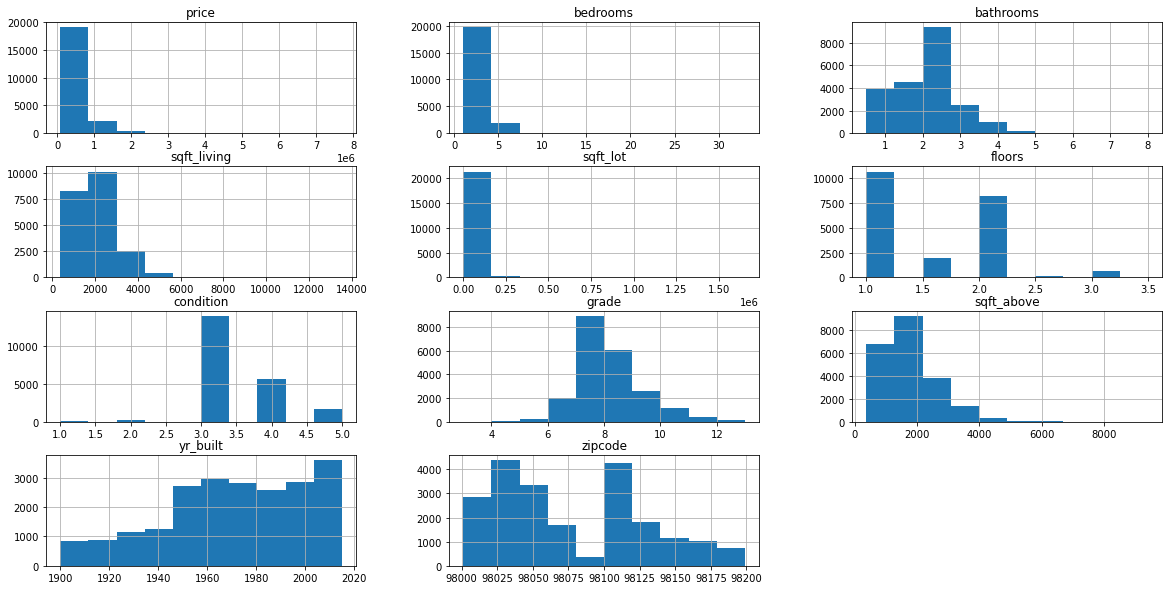

In [14]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df_filtered.hist(ax = ax);

## Check for Multicollinearity

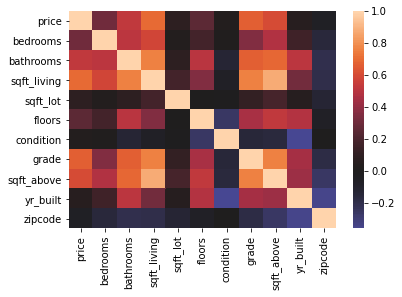

In [15]:
sns.heatmap(df_filtered.corr(), center=0);

## Model A (Simple Model)

In [16]:
price = y_train
bedrooms = X_train['bedrooms']
bathrooms = X_train['bathrooms']
sqft_living = X_train['sqft_living']
grade = X_train['grade']

In [17]:
simple_model_ols = pd.concat([price, bedrooms, bathrooms, sqft_living, grade], axis=1)
simple_model_ols.head()

,price,bedrooms,bathrooms,sqft_living,grade
6243,332500.0,4,2.00,1440,7
8986,390000.0,3,1.75,1430,7
9419,800000.0,4,2.75,3120,9
10155,462000.0,4,2.50,2060,7
10436,695000.0,3,2.00,2500,7


In [18]:
outcome = 'price'
predictors = simple_model_ols.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [19]:
model = ols(formula=formula, data=simple_model_ols).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5184.
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:48:37   Log-Likelihood:            -2.3917e+05
No. Observations:               17277   AIC:                         4.783e+05
Df Residuals:                   17272   BIC:                         4.784e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -4.87e+05    1.7e+04    -28.689      0.000    -5.2e+05   -4.54e+05
bedrooms    -4.335e+04   2685.131    -16.143      0.000   -4.86e+04   -3.81e+04
bathrooms   -2.448e+04   3936.106     -6.219      0.000   -3.22e+04   -1.68e+04
sqft_living   227.8517      4.065     56.054      0.000     219.884     235.819
grade        9.819e+04   2607.614     37.654      0.000    9.31e+04    1.03e+05
==============================================================================
Omnibus:                    12674.639   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           584848.422
Skew:                           3.045   Prob(JB):                         0.00
Kurtosis:                      30.845   Cond. No.                     2.07e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
y = simple_model_ols['price']
linreg = LinearRegression()
linreg.fit(predictors, y)

LinearRegression()

In [21]:
linreg.coef_

array([-43346.87097738, -24480.19836325,    227.8517448 ,  98187.07710573])

In [22]:
linreg.intercept_

-487046.2750142581

## Cross Validation

# Model B

## Create Dummy Variables

In [23]:
X_train['yr_built'] = X_train['yr_built'].astype('str')
X_train['zipcode'] = X_train['zipcode'].astype('str')
X_train['floors'] = X_train['floors'].astype('str')

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   bedrooms     21597 non-null  int64  
 2   bathrooms    21597 non-null  float64
 3   sqft_living  21597 non-null  int64  
 4   sqft_lot     21597 non-null  int64  
 5   floors       21597 non-null  float64
 6   condition    21597 non-null  int64  
 7   grade        21597 non-null  int64  
 8   sqft_above   21597 non-null  int64  
 9   yr_built     21597 non-null  int64  
 10  zipcode      21597 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1.8 MB


In [24]:
zip_dummies = pd.get_dummies(X_train['zipcode'], prefix='zip', drop_first=True)
yr_dummies = pd.get_dummies(X_train['yr_built'], prefix='yr', drop_first=True)
floor_dummies = pd.get_dummies(X_train['floors'], prefix='flr', drop_first=True)

In [25]:
df_dummies = X_train.drop(['zipcode','yr_built','floors'], axis=1)

In [26]:
df_dummies = pd.concat([X_train, zip_dummies, yr_dummies, floor_dummies], axis=1)
df_dummies.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,zipcode,...,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015,flr_1.5,flr_2.0,flr_2.5,flr_3.0,flr_3.5
6243,4,2.00,1440,4855,2.0,4,7,1440,1972,98144,...,0,0,0,0,0,0,1,0,0,0
8986,3,1.75,1430,9857,1.0,4,7,1140,1980,98045,...,0,0,0,0,0,0,0,0,0,0
9419,4,2.75,3120,5000,2.0,3,9,3120,2010,98074,...,0,0,0,0,0,0,1,0,0,0
10155,4,2.50,2060,6958,1.0,3,7,1220,1974,98034,...,0,0,0,0,0,0,0,0,0,0
10436,3,2.00,2500,4080,1.5,5,7,1680,1922,98103,...,0,0,0,0,0,1,0,0,0,0


## Log Transformations

In [27]:
logsqft = np.log(X_train['sqft_living'])

## Feature Scaling

In [28]:
scaled_sqft = (logsqft-np.mean(logsqft))/np.sqrt(np.var(logsqft))

## Model Training

In [29]:
data_fin = pd.DataFrame([])
price = y_train
bedrooms = X_train['bedrooms']
bathrooms = X_train['bathrooms']          

In [30]:
model_b = pd.concat([price, bedrooms, bathrooms, scaled_sqft, zip_dummies, yr_dummies], axis=1)
model_b.head()

,price,bedrooms,bathrooms,sqft_living,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,...,yr_2006,yr_2007,yr_2008,yr_2009,yr_2010,yr_2011,yr_2012,yr_2013,yr_2014,yr_2015
6243,332500.0,4,2.00,-0.661456,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8986,390000.0,3,1.75,-0.677909,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9419,800000.0,4,2.75,1.164064,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10155,462000.0,4,2.50,0.183939,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10436,695000.0,3,2.00,0.640997,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y = price
x = model_b.drop('price', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum

In [32]:
model = ols(formula=formula, data=model_b).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     3988.
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:48:37   Log-Likelihood:            -2.4033e+05
No. Observations:               17277   AIC:                         4.807e+05
Df Residuals:                   17272   BIC:                         4.807e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.569e+05   2.46e+04    -22.683      0.000   -6.05e+05   -5.09e+05
bedrooms    -1.751e+04   2995.195     -5.847      0.000   -2.34e+04   -1.16e+04
bathrooms    2.118e+04   4236.987      4.998      0.000    1.29e+04    2.95e+04
sqft_living  9.764e+04   4077.953     23.944      0.000    8.96e+04    1.06e+05
grade        1.453e+05   2722.931     53.365      0.000     1.4e+05    1.51e+05
==============================================================================
Omnibus:                    15377.438   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1343701.689
Skew:                           3.908   Prob(JB):                         0.00
Kurtosis:                      45.491   Cond. No.                         108.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Evaluate

In [36]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [37]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [38]:
y_pred = model.predict(X_test)
print(y_pred)

[126630.84107502 309612.08476249 302236.04631545 ... 548740.86997604
 399949.33141866 209274.11750526]


In [ ]:
model.score(x,y)

In [ ]:
num = 20
train_err = []
test_err = []
for i in range(num):
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [ ]:
cv_5_results  = np.mean(cross_val_score(linreg, features, target, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, features, target, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, features, target, cv=20, scoring='neg_mean_squared_error'))

In [ ]:
cv_5_results

In [ ]:
cv_10_results

In [ ]:
cv_20_results

## Model C

In [ ]:
updated_zip = zip_dummies.drop(['zip_98002','zip_98003','zip_98023','zip_98030','zip_98031',
                                'zip_98032','zip_98038','zip_98042',
                 'zip_98092','zip_98188'], axis=1)
updated_zip

In [ ]:
updated_yr = yr_dummies.drop([])

## Model D

## Feature Engineering

## Model Training

## Model Evaluation

## Conclusions/Summary